Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

•	DateCrawled — дата скачивания анкеты из базы

•	VehicleType — тип автомобильного кузова

•	RegistrationYear — год регистрации автомобиля

•	Gearbox — тип коробки передач

•	Power — мощность (л. с.)

•	Model — модель автомобиля

•	Kilometer — пробег (км)

•	RegistrationMonth — месяц регистрации автомобиля

•	FuelType — тип топлива

•	Brand — марка автомобиля

•	NotRepaired — была машина в ремонте или нет

•	DateCreated — дата создания анкеты

•	NumberOfPictures — количество фотографий автомобиля

•	PostalCode — почтовый индекс владельца анкеты (пользователя)

•	LastSeen — дата последней активности пользователя


# 1. Подготовка данных

In [81]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [82]:
df = pd.read_csv('autos.csv')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [84]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [85]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Заменим все модели со значением nan на самые частые по бренду

In [86]:
def f(x):
    if x.notna().sum():
        return x.fillna(x.mode()[0])
    else:
        return x

df['Model'] = df.groupby('Brand')['Model'].apply(f)

In [87]:
df.Model.isna().sum()

3374

Осталось не так много нанов, их можно удалить

In [88]:
df = df[df.Model.notna()]

In [89]:
df['NotRepaired'].value_counts()

no     245346
yes     35818
Name: NotRepaired, dtype: int64

In [90]:
df['VehicleType'] = df.groupby('Brand')['VehicleType'].transform( lambda x: x.fillna((x.mode()[0])))

Псмотрим на распределение цен

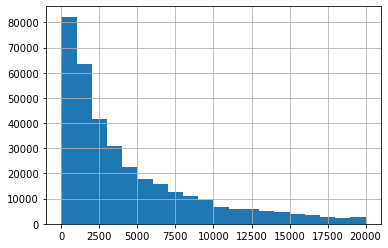

In [91]:
df.Price.hist(bins=20)

In [92]:
df[df.Price == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,small,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,sedan,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,golf,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,small,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


Оставим только те автомобили, у которых есть цены

In [93]:
df = df[df.Price != 0]

Оставим только адекватные года

In [94]:
df = df[(df.RegistrationYear <= 2020) & (df.RegistrationYear > 1920)]

Создадим переменную, содержащую дату в нормальном формате

In [95]:
def stringify_mounth(x):
    if x == 0:
        x = 1
    return ('0' if x < 10 else '') + str(x)

df['RegistrationDate'] = df.RegistrationYear.apply(str).values + '-' + \
df.RegistrationMonth.apply(stringify_mounth).values + '-01'


Создадим переменную "Сколько дней прошло от регистрации до создания объявления"

In [96]:
df['time_until_sell'] = (pd.to_datetime(df.DateCreated) - pd.to_datetime(df.RegistrationDate)).apply(lambda x: int(str(x).split(' ')[0]))

In [97]:
df = df[df['time_until_sell'] >= 0]

Удалим ненужные поля

In [98]:
df.drop(['NumberOfPictures', 'PostalCode', 'LastSeen', 
         'RegistrationMonth', 'DateCrawled', 'DateCreated',
         'RegistrationDate'], axis=1, inplace=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,time_until_sell
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN,8483
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes,1789
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,4243
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,5403
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2830
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,4340
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,5870
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,5848
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,7323


Поработаем с полем Power. Заменим нули на nan, чтобы впоследствии заменить значение на среднее по бренду и модели

In [99]:
df.Power[df.Power == 0] = np.nan

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Также заменяем NaN'ы для типа топлива и коробки передач 

In [100]:
for col in ['FuelType', 'Gearbox']:    
    print("Column: {}. NaN's: {}".format(col, df[col].isna().sum()))
    df[col] = df.groupby(['Brand', 'Model'])[col].transform(lambda x: x.fillna((x.mode()[0])))
    df[col] = df.groupby(['Brand'])[col].transform(lambda x: x.fillna((x.mode()[0])))
    print("after process: {}".format(df[col].isna().sum()))
    

df.Power = df.groupby(['Brand', 'Model']).Power.transform(lambda x: x.fillna(x[x != np.nan].mean()))
df.Power = df.groupby(['Brand']).Power.transform(lambda x: x.fillna(x[x != np.nan].mean()))
df.Power.isna().sum()

Column: FuelType. NaN's: 21535
after process: 0
Column: Gearbox. NaN's: 14490
after process: 0


0

Отремонтированные автомобили сильно преобладают. Заменим NaN'ы на самое частое значение 'no'

In [101]:
df.NotRepaired = df.NotRepaired.fillna('no')

In [102]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
time_until_sell     0
dtype: int64

1000 Л.С. - слишком много. Удалим

In [103]:
df[df.Power > 1000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,time_until_sell
1816,3200,small,2004,manual,1398.0,corolla,5000,petrol,toyota,no,4312
5328,500,wagon,1999,manual,1001.0,astra,150000,petrol,opel,no,6116
7661,1499,small,1999,manual,7515.0,lupo,150000,petrol,volkswagen,no,6211
7720,1500,small,2000,manual,1400.0,civic,150000,petrol,honda,no,5936
9664,2599,small,2016,manual,1779.0,zafira,150000,petrol,opel,no,73
...,...,...,...,...,...,...,...,...,...,...,...
348668,1000,wagon,1996,manual,2598.0,a6,150000,gasoline,audi,no,7187
348883,7500,sedan,2011,manual,1548.0,scenic,90000,petrol,renault,no,1808
348968,250,small,1999,manual,1241.0,ypsilon,150000,petrol,lancia,yes,6183
351947,1500,bus,2001,manual,1001.0,zafira,5000,gasoline,opel,no,5363


In [104]:
df = df[df.Power <= 1000]

Посмотрим количество записей для каждого бренда

In [105]:
df[df.Brand.notna()].Brand.value_counts()

volkswagen       69492
opel             35899
bmw              34418
mercedes_benz    29959
audi             27297
ford             23086
renault          16088
peugeot          10264
fiat              8730
seat              6221
skoda             5244
mazda             5162
smart             4897
citroen           4725
nissan            4551
toyota            4346
hyundai           3364
mini              3040
volvo             3023
mitsubishi        2768
honda             2550
kia               2273
suzuki            2157
alfa_romeo        2120
chevrolet         1636
chrysler          1309
dacia              857
daihatsu           732
porsche            720
subaru             706
jeep               628
land_rover         524
saab               503
daewoo             493
jaguar             488
trabant            480
lancia             429
rover              427
lada               203
Name: Brand, dtype: int64

Минимальное количество - 203. Хорошо, можем закодировать ценовые статистики для каждого бренда 

In [106]:
df['Brand_price_std'] = df.groupby(['Brand']).Price.transform(lambda x: x.std())
df['Brand_price_mean'] = df.groupby(['Brand']).Price.transform(lambda x: x.mean())
for per in [25, 50, 75]:
    df['Brand_price_per_{}'.format(per)] = df.groupby(['Brand']).Price.transform(lambda x: x.quantile(per / 100))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [107]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,time_until_sell,Brand_price_std,Brand_price_mean,Brand_price_per_25,Brand_price_per_50,Brand_price_per_75
0,480,sedan,1993,manual,106.076187,golf,150000,petrol,volkswagen,no,8483,4511.585165,4623.809215,1250.0,2900.0,6799.0
1,18300,coupe,2011,manual,190.000000,a4,125000,gasoline,audi,yes,1789,5277.565790,6529.007363,2000.0,4999.0,9999.0
2,9800,suv,2004,auto,163.000000,grand,125000,gasoline,jeep,no,4243,4825.416926,7361.339172,3600.0,6199.5,9991.0
3,1500,small,2001,manual,75.000000,golf,150000,petrol,volkswagen,no,5403,4511.585165,4623.809215,1250.0,2900.0,6799.0
4,3600,small,2008,manual,69.000000,fabia,90000,gasoline,skoda,no,2830,4473.790161,6048.643974,2500.0,4900.0,8500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225.000000,leon,150000,petrol,seat,yes,4340,4090.464043,4204.157531,1050.0,2750.0,6300.0
354363,1150,bus,2000,manual,132.929379,zafira,150000,petrol,opel,no,5870,3247.841321,2883.327029,790.0,1650.0,3800.0
354366,1199,convertible,2000,auto,101.000000,fortwo,125000,petrol,smart,no,5848,2459.524516,3598.609353,1800.0,2950.0,4900.0
354367,9200,bus,1996,manual,102.000000,transporter,150000,gasoline,volkswagen,no,7323,4511.585165,4623.809215,1250.0,2900.0,6799.0


In [108]:
for c in df.columns:
    print("{}: {} unique values".format(c, df[c].unique().shape[0]))

Price: 3667 unique values
VehicleType: 8 unique values
RegistrationYear: 87 unique values
Gearbox: 2 unique values
Power: 752 unique values
Model: 250 unique values
Kilometer: 13 unique values
FuelType: 7 unique values
Brand: 39 unique values
NotRepaired: 2 unique values
time_until_sell: 13741 unique values
Brand_price_std: 39 unique values
Brand_price_mean: 39 unique values
Brand_price_per_25: 29 unique values
Brand_price_per_50: 37 unique values
Brand_price_per_75: 35 unique values


Применим one hot encoding к переменным с небольшим количеством уникальных значений

In [109]:
one_hot = df
cols = ['Gearbox', 'FuelType', 'VehicleType']
for col in cols:
    one_hot = one_hot.join(pd.get_dummies(df[col]), on=df.index, rsuffix=col)

one_hot.drop(cols, axis=1, inplace=True)

Остальные категориальные признаки факторизуем

In [110]:
for col in ['Model', 'Brand', 'NotRepaired']:
    print(col)
    one_hot[col] = one_hot[col].factorize()[0]

Model
Brand
NotRepaired


In [111]:
one_hot

,Price,RegistrationYear,Power,Model,Kilometer,Brand,NotRepaired,time_until_sell,Brand_price_std,Brand_price_mean,...,other,petrol,bus,convertible,coupe,otherVehicleType,sedan,small,suv,wagon
0,480,1993,106.076187,0,150000,0,0,8483,4511.585165,4623.809215,...,0,1,0,0,0,0,1,0,0,0
1,18300,2011,190.000000,1,125000,1,1,1789,5277.565790,6529.007363,...,0,0,0,0,1,0,0,0,0,0
2,9800,2004,163.000000,2,125000,2,0,4243,4825.416926,7361.339172,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.000000,0,150000,0,0,5403,4511.585165,4623.809215,...,0,1,0,0,0,0,0,1,0,0
4,3600,2008,69.000000,3,90000,3,0,2830,4473.790161,6048.643974,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225.000000,115,150000,11,1,4340,4090.464043,4204.157531,...,0,1,0,0,0,0,1,0,0,0
354363,1150,2000,132.929379,87,150000,14,0,5870,3247.841321,2883.327029,...,0,1,1,0,0,0,0,0,0,0
354366,1199,2000,101.000000,24,125000,16,0,5848,2459.524516,3598.609353,...,0,1,0,1,0,0,0,0,0,0
354367,9200,1996,102.000000,18,150000,0,0,7323,4511.585165,4623.809215,...,0,0,1,0,0,0,0,0,0,0


Посмотрим самые скоррелированные признаки

In [112]:
one_hot.corr().Price[one_hot.corr().Price.abs().sort_values().index]

cng                  -0.000578
sedan                 0.003522
other                -0.008297
electric              0.008553
lpg                  -0.015651
otherVehicleType     -0.017335
hybrid                0.027009
wagon                 0.036427
bus                   0.064111
coupe                 0.075227
Brand                -0.087118
Model                 0.094182
convertible           0.126301
suv                   0.189216
NotRepaired          -0.189454
manual               -0.253923
auto                  0.253923
small                -0.259599
petrol               -0.285043
gasoline              0.292431
Brand_price_std       0.294168
Brand_price_per_25    0.296119
Brand_price_per_50    0.324541
Brand_price_per_75    0.329851
Brand_price_mean      0.331790
Kilometer            -0.359664
Power                 0.487165
RegistrationYear      0.498608
time_until_sell      -0.501030
Price                 1.000000
Name: Price, dtype: float64

Разобьем на матрицу признаков и таргеты

In [113]:
X, y = one_hot.drop(['Price'], axis=1).values, one_hot.Price.values

Обучающая и тестовая выборка

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
del X

# 2. Обучение моделей

In [129]:
import time

start_time = time.time()

for est_num in [5, 10, 25, 50, 100]:
    print("estimators number: {}".format(est_num))
    reg = XGBRegressor(n_estimators=est_num)
    reg.fit(X_train, y_train)
    print("fit time: {:.4}s".format(time.time() - start_time))
    start_time = time.time()
    reg.predict(X_test)
    print("predict time: {:.4}s\n".format(time.time() - start_time))
    start_time = time.time()
    

estimators number: 5
fit time: 2.402s
predict time: 0.02996s

estimators number: 10
fit time: 4.368s
predict time: 0.03203s

estimators number: 25
fit time: 10.06s
predict time: 0.03913s

estimators number: 50
fit time: 19.15s
predict time: 0.05805s

estimators number: 100
fit time: 43.55s
predict time: 0.07994s



Будем обучать модель с кросс-валидацией на 5 фолдах, т.е. время обучения увеличится ~ в 5 раз. Возьмем модель с 5 деревьями. Возьмем метрику RMSE для поиска наилучшей модели

In [130]:
folds = 5
cv = KFold(folds)
def counter(func):
    i = 0
    cv_score = []
    def the_wrapper_around_the_original_function(*args):
        res = func(*args)
        nonlocal i, cv_score
        global folds
        i += 1
        if i == folds:
            sc = np.array(cv_score).mean()
            print("score: {}".format(sc))
            cv_score = []
            i = 0
        cv_score.append(res)
        return res
    return the_wrapper_around_the_original_function

@counter
def rmse(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred) ** 0.5
    return score

scorer = make_scorer(rmse, greater_is_better=False)

In [131]:
params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.logspace(1, 2, 2, base=0.1),
    'booster': ['gbtree', 'gblinear', 'dart']
}
reg = GridSearchCV(XGBRegressor(n_estimators=5), params, cv=cv, scoring=scorer)
reg.fit(X_train, y_train)

score: 4448.632284755895
score: 4309.468344504528
score: 4212.0767943927785
score: 4155.97672587574
score: 5819.798691493992
score: 6220.986992343303
score: 6210.515847537416
score: 6204.618826855554
score: 4326.294402361711
score: 3858.932832666139
score: 3858.841384747959
score: 3857.9565680153682
score: 4772.55856327581
score: 4998.97830605327
score: 4999.005745885797
score: 4998.978925601173
score: 4556.335496974269
score: 4309.468344504528
score: 4212.0767943927785
score: 4155.976725871103
score: 5819.798691493992
score: 6220.986992343303
score: 6210.515847537416
score: 6204.618826855554


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': array([0.1 , 0.01]),
                         'm

In [132]:
reg.best_score_, reg.best_params_

(-3857.977633583788,
 {'booster': 'gblinear', 'learning_rate': 0.1, 'max_depth': 9})

Попробуем увеличить количество деревьев, оставив лучшие параметры

In [133]:
params = {
    'n_estimators': [10, 25, 50, 75]
}
reg_ = GridSearchCV(XGBRegressor(**reg.best_params_), params, cv=cv, scoring=scorer)
reg_.fit(X_train, y_train)

score: 4164.6540450502225
score: 3440.5479653279663
score: 3211.1249380085565
score: 3077.061116098421


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster='gblinear',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=9, min_child_weight=N...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
           

In [134]:
reg = XGBRegressor(**reg.best_params_, **reg_.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=9,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=75, n_jobs=0, num_parallel_tree=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=False, verbosity=None)

In [135]:
pred = reg.predict(X_test)

In [136]:
best_score = rmse(y_test, pred)
best_reg = reg
best_score

3046.1973158823807

Проделаем всё то же самое для регрессора из библиотеки LightGBM

In [137]:
start_time = time.time()

for est_num in [10, 25, 50, 100, 250]:
    print("estimators number: {}".format(est_num))
    reg = LGBMRegressor(n_estimators=est_num)
    reg.fit(X_train, y_train)
    print("fit time: {:.4}s".format(time.time() - start_time))
    start_time = time.time()
    reg.predict(X_test)
    print("predict time: {:.4}s\n".format(time.time() - start_time))
    start_time = time.time()
    

estimators number: 10
fit time: 0.6363s
predict time: 0.02294s

estimators number: 25
fit time: 0.9472s
predict time: 0.03595s

estimators number: 50
fit time: 1.432s
predict time: 0.06092s

estimators number: 100
fit time: 2.121s
predict time: 0.1099s

estimators number: 250
fit time: 3.874s
predict time: 0.2134s



Видим, что в библиотеке LightGBM модели обучаются на порядок быстрее. Возьмем за основу модель с 25 деревьями

In [150]:
params = {
    'max_depth': [3, 5, 7, 9, -1],
    'learning_rate': np.logspace(1, 2, 2, base=0.1),
    'boosting_type': ['gbdt', 'goss', 'dart', 'rf']
}

reg = GridSearchCV(LGBMRegressor(n_estimators=25), params, cv=cv, scoring=scorer)
reg.fit(X_train, y_train)

score: 4086.6621559310224
score: 2213.5589393522364
score: 1981.752150325006
score: 1941.879784101299
score: 1938.6802813403406
score: 2343.5746187764244
score: 3940.6062282520675
score: 3840.948824124501
score: 3831.5811469127716
score: 3831.577230209144
score: 5358115169322.342
score: 5161202760436244.0
score: 2.473893063005337e+17
score: 2.200294467031948e+20
score: 2.1933028260268524e+21
score: 1.1711230307103313e+20
score: 3940.6062282520675
score: 3840.948824124501
score: 3831.5811469127716
score: 3831.577230209144
score: 3539.0913681990132
score: 2315.2446990720573
score: 2068.7844736016586
score: 2034.8914162851052
score: 2032.122740027622
score: 2434.2274189165864
score: 4023.995485665199
score: 3938.5020133161634
score: 3930.6742549591786
score: 3930.724011948877


c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at d:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


  FitFailedWarning)
c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at d:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


  FitFailedWarning)
c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Esti

c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at d:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


  FitFailedWarning)
c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at d:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


  FitFailedWarning)
c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Esti

c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at d:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


  FitFailedWarning)
c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at d:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


  FitFailedWarning)
c:\program files\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Esti

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=25, n_jobs=-1, num_leaves=31,
                                     objective=None, random_stat...
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'boosting_type': ['gbdt', 'goss', 'dart', 'rf'],
                         'learning_rate': array([0.1 , 0.01]),
                         'max_depth': [3, 5, 7, 9, -1]},
         

In [151]:
params = {
    'n_estimators': [25, 50, 75, 100]
}
reg_ = GridSearchCV(LGBMRegressor(**reg.best_params_), params, cv=cv, scoring=scorer)
reg_.fit(X_train, y_train)

score: 3532.1644856616913
score: 1906.8263109401846
score: 1763.5051198846509
score: 1719.5449809131308


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [25, 50, 75, 100]},
             pre_dispatch='2*n_jobs', refit=True, return

In [152]:
reg = LGBMRegressor(**reg.best_params_, **reg_.best_params_)
reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [153]:
pred = reg.predict(X_test)

In [154]:
score = rmse(y_test, pred)
score

1701.1288987370287

In [155]:
if score < best_score:
    best_score = score
    best_reg = reg
best_reg.__class__.__name__, best_score

('LGBMRegressor', 1701.1288987370287)

И проверим регрессор из библиотеки CatBoost

In [156]:
start_time = time.time()

for est_num in [10, 25, 50, 100, 250]:
    print("estimators number: {}".format(est_num))
    reg = CatBoostRegressor(n_estimators=est_num)
    reg.fit(X_train, y_train, verbose=0)
    print("fit time: {:.4}s".format(time.time() - start_time))
    start_time = time.time()
    reg.predict(X_test)
    print("predict time: {:.4}s\n".format(time.time() - start_time))
    start_time = time.time()
    

estimators number: 10
fit time: 2.334s
predict time: 0.1326s

estimators number: 25
fit time: 2.901s
predict time: 0.1407s

estimators number: 50
fit time: 4.178s
predict time: 0.1338s

estimators number: 100
fit time: 6.309s
predict time: 0.1347s

estimators number: 250
fit time: 12.76s
predict time: 0.1356s



CatBoost чуть медленнее, чем LightGBM, но всё равно намного быстрее XGBoost. Возьмем опять 25 деревьев

In [157]:
params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.logspace(1, 4, 4, base=0.1)
}

reg = GridSearchCV(CatBoostRegressor(n_estimators=25), params, cv=cv, scoring=scorer)
reg.fit(X_train, y_train, verbose=0)

score: 1700.2374635003184
score: 2397.143386934916
score: 2185.182499465759
score: 2058.7040703018292
score: 1974.0557299756663
score: 4001.4256536471794
score: 3921.4099368931165
score: 3873.1360012243977
score: 3837.2517406970283
score: 4485.431992133291
score: 4476.801639186353
score: 4471.18195959613
score: 4467.245101722673
score: 4541.5130348918565
score: 4540.645055069278
score: 4540.080836992958


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000027807102780>,
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.1   , 0.01  , 0.001 , 0.0001]),
                         'max_depth': [3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(the_wrapper_around_the_original_function, greater_is_better=False),
             verbose=0)

In [158]:
reg.best_score_

-1974.0557299756663

In [159]:
params = {
    'n_estimators': [25, 50, 75, 100]
}
reg_ = GridSearchCV(CatBoostRegressor(**reg.best_params_), params, cv=cv, scoring=scorer)
reg_.fit(X_train, y_train, verbose=0)

score: 4539.671493848458
score: 1974.0557299756663
score: 1798.5875459210026
score: 1742.3555057671606


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000027807CDB780>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [25, 50, 75, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(the_wrapper_around_the_original_function, greater_is_better=False),
             verbose=0)

In [160]:
reg = CatBoostRegressor(**reg.best_params_, **reg_.best_params_)
reg.fit(X_train, y_train)

0:	learn: 4223.6270888	total: 70.3ms	remaining: 6.96s
1:	learn: 3939.0961975	total: 133ms	remaining: 6.51s
2:	learn: 3689.0126185	total: 217ms	remaining: 7.01s
3:	learn: 3467.7661784	total: 282ms	remaining: 6.78s
4:	learn: 3273.4274677	total: 357ms	remaining: 6.79s
5:	learn: 3099.4373350	total: 432ms	remaining: 6.76s
6:	learn: 2947.8135485	total: 521ms	remaining: 6.93s
7:	learn: 2818.4576087	total: 589ms	remaining: 6.77s
8:	learn: 2704.9174392	total: 675ms	remaining: 6.83s
9:	learn: 2603.4992093	total: 777ms	remaining: 6.99s
10:	learn: 2516.1021888	total: 857ms	remaining: 6.93s
11:	learn: 2438.5210423	total: 939ms	remaining: 6.88s
12:	learn: 2369.9878286	total: 1.02s	remaining: 6.83s
13:	learn: 2307.7040158	total: 1.11s	remaining: 6.8s
14:	learn: 2251.2683003	total: 1.18s	remaining: 6.69s
15:	learn: 2207.8541653	total: 1.26s	remaining: 6.62s
16:	learn: 2167.2809702	total: 1.34s	remaining: 6.54s
17:	learn: 2129.0990329	total: 1.42s	remaining: 6.47s
18:	learn: 2098.6834230	total: 1.53s	r

In [161]:
pred = reg.predict(X_test)

In [162]:
score = rmse(y_test, pred)
score

score: 1709.8645132354457


1708.150123548917

In [163]:
if score < best_score:
    best_score = score
    best_reg = reg
best_reg.__class__.__name__, best_score

('LGBMRegressor', 1701.1288987370287)

In [164]:
y.mean()

4629.320382587187

# 3. Анализ моделей

Регрессоры из библиотек LightGBM и CatBoost показали себя намного лучше, чем регрессор на базе XGBoost. Обе библиотеки намного быстрее третьей, и точность у них намного выше. Самый быстрый - LGBMRegressor.
<BR><BR>
Результаты по метрике RMSE:

1) LGBM - 1701.129 ~ 36% от среднего значения цен (4629.32)

2) CatBoost - 1708.15 

3) XGBoost - 3046.197 ~ 66% от среднего значения цен
<BR><BR>

Скорость предсказания у всех трех библиотек примерно одинаковая и очень высокая по сравнению со скоростью обучения, что логично, т.к. для предсказания требуется намного меньшее количество вычислительной мощности, чем для обучения
    
    
Вывод: Библиотека LightGBM показала лучший скор, а также лучший показатель по скорости обучения. Следующей идет библиотека CatBoost - скорость пониже, чем у предыдущей, точность примерно такая же. Замыкает тройку библиотека XGBoost, Она работает намного медленнее предыдущих, следовательно тяжелее подобрать подходящие гиперпараметры для лучшего результата

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей